To upload local file in google colab

In [7]:
from google.colab import files
# Upload the CSV file from your computer if you are on Google Collab
uploaded = files.upload()
!unzip Data.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Data/train/dandelion/2166831869_1f83e382d2_c.jpg  
  inflating: __MACOSX/Data/train/dandelion/._2166831869_1f83e382d2_c.jpg  
  inflating: Data/train/dandelion/464471792_f54fa4a7a2_c.jpg  
  inflating: __MACOSX/Data/train/dandelion/._464471792_f54fa4a7a2_c.jpg  
  inflating: Data/train/dandelion/8393161712_e20ce4d588_c.jpg  
  inflating: __MACOSX/Data/train/dandelion/._8393161712_e20ce4d588_c.jpg  
  inflating: Data/train/dandelion/6790984536_86992a3d0d_c.jpg  
  inflating: __MACOSX/Data/train/dandelion/._6790984536_86992a3d0d_c.jpg  
  inflating: Data/train/dandelion/6062909644_ca45ba6d7f_c.jpg  
  inflating: __MACOSX/Data/train/dandelion/._6062909644_ca45ba6d7f_c.jpg  
  inflating: Data/train/dandelion/6975068358_0c9dcc41aa_c.jpg  
  inflating: __MACOSX/Data/train/dandelion/._6975068358_0c9dcc41aa_c.jpg  
  inflating: Data/train/dandelion/9046346911_c7df312b57_c.jpg  
  inflating: __MACOSX/Data

Libraries

In [8]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Part 1: Data Exploration And Visualization

1. Objective: Familiarize yourself with the dataset.
2. Task:

Load the dataset using image_dataset_from_directory.
Print the number of images per class.
Modify the visualize_images function to display a grid of 3x3 images for each flower class. Ensure the class name is displayed as the title for each grid.
Analyze the images. What are some challenges you anticipate in classifying these flowers? (e.g., similar colors, shapes, variations within a species).

In [9]:
#Load the dataset using image_dataset_from_directory.

train_dir = "Data/train"
val_dir = "Data/val"

img_height = 128
img_width = 128
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)
print(train_ds)



Found 13642 files belonging to 14 classes.
Found 98 files belonging to 14 classes.
Classes: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip', 'water_lily']
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [10]:
#Print the number of images per class.

def count_images_per_class(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

print("Train images per class:")
train_counts = count_images_per_class(train_dir)
print(train_counts)

print("\nValidation images per class:")
val_counts = count_images_per_class(val_dir)
print(val_counts)


Train images per class:
{'carnation': 924, 'calendula': 1011, 'black_eyed_susan': 986, 'sunflower': 1013, 'tulip': 1034, 'coreopsis': 1035, 'dandelion': 1038, 'rose': 986, 'california_poppy': 1021, 'astilbe': 726, 'water_lily': 977, 'iris': 1041, 'common_daisy': 978, 'bellflower': 872}

Validation images per class:
{'carnation': 7, 'calendula': 7, 'black_eyed_susan': 7, 'sunflower': 7, 'tulip': 7, 'coreopsis': 7, 'dandelion': 7, 'rose': 7, 'california_poppy': 7, 'astilbe': 7, 'water_lily': 7, 'iris': 7, 'common_daisy': 7, 'bellflower': 7}


<Figure size 600x600 with 0 Axes>

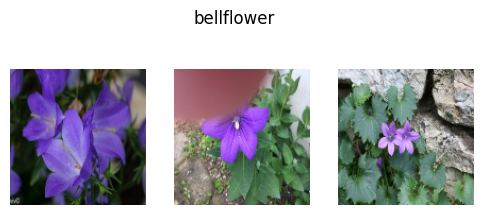

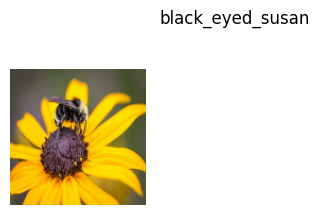

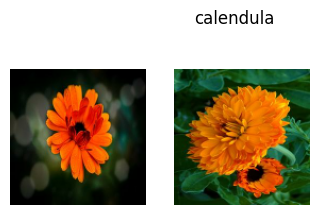

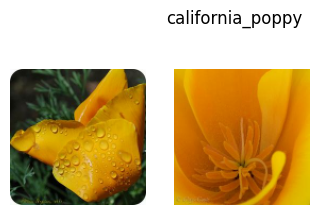

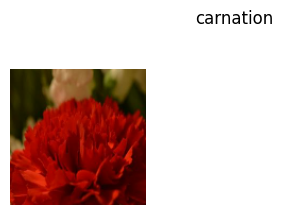

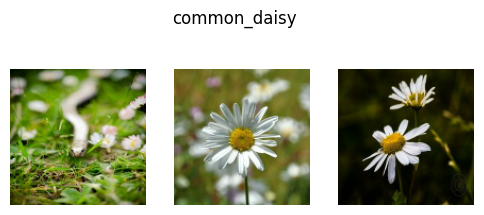

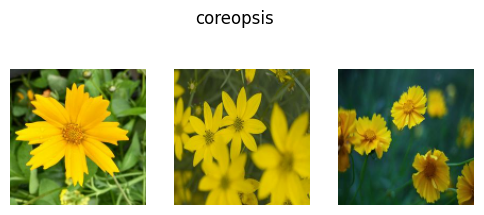

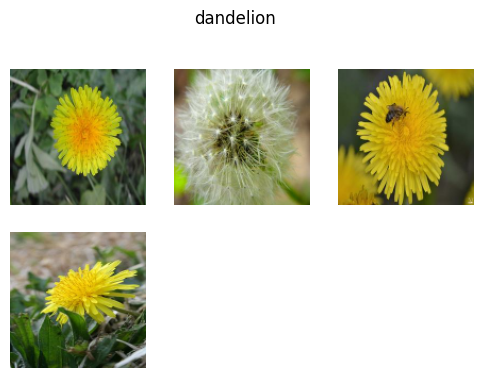

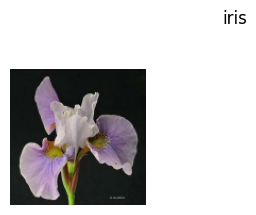

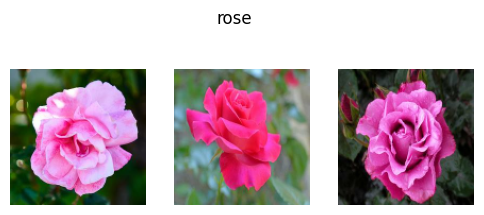

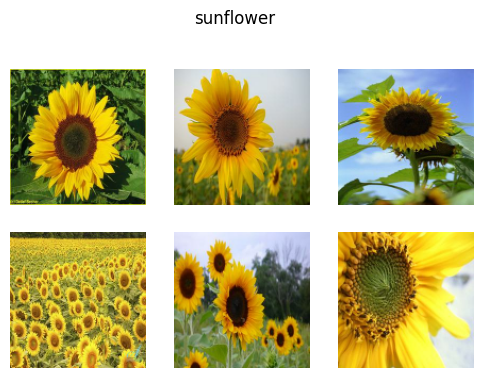

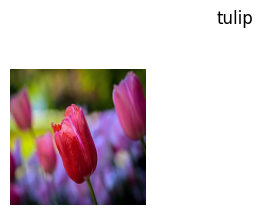

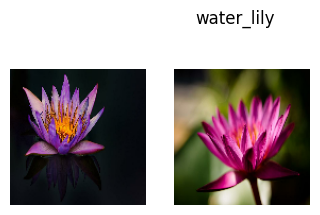

In [11]:
#Modify the visualize_images function to display a grid of 3x3 images for each flower class.
#Ensure the class name is displayed as the title for each grid.

def visualize_images(dataset, class_names):
    for images, labels in dataset.take(1):
        for class_index, class_name in enumerate(class_names):
            idxs = tf.where(labels == class_index)
            idxs = tf.squeeze(idxs)
            idxs = np.atleast_1d(idxs.numpy())

            plt.figure(figsize=(6,6))
            for i in range(9):
                if i < len(idxs):
                    plt.subplot(3, 3, i+1)
                    idx = idxs[i]
                    plt.imshow(images[idx].numpy().astype("uint8"))
                    plt.axis("off")
            plt.suptitle(class_name)
            plt.show()

visualize_images(train_ds, class_names)



Analyze the images. What are some challenges you anticipate in classifying these flowers? (e.g., similar colors, shapes, variations within a species).

After visualizing the dataset, several potential challenges in accurately classifying these flower images emerge:

Similar Shapes Between Classes
Some flower species share very similar shapes and petal arrangements.
Example: Calendula vs. sunflower — both can have round yellow petals and similar centers, which may confuse the model.

High Intra-Class Variation
Flowers within the same class may have significant differences in shape, size, or structure.
Example: Astilbe flowers can appear as dense plumes or sparse clusters, increasing intra-class diversity.

Orientation and Position
Flowers can be captured from various angles (top-down, side view, diagonal), which may change their perceived shape.
Varying orientations make it harder for the model to learn consistent features.

Focus and Depth of Field
Some images might be blurry or have parts of the flower out of focus, which reduces clarity of key features.
Shallow depth of field can cause parts of the flower to blend with the background.

Color Variations Within a Class
Flowers of the same species may exhibit different colors due to natural variations or lighting.
Example: Tulips can have many color combinations, which could overlap with other classes.

Color Gradients and Lighting Conditions
Natural lighting creates shadows and color gradients that can distort the true colors and edges of petals.
Reflections on petals can also confuse the model by adding unexpected highlights.

Background Complexity
Images may have busy backgrounds with other plants, grass, or objects that partially occlude the flower.
The model must learn to focus on the flower and ignore irrelevant details.

Part 2: Model Architecture Design

1. Objective: Design a CNN architecture suitable for this task.
2. Task:

Start with the provided model architecture.
Experiment with the number of convolutional layers, filters, kernel sizes, and max-pooling layers.
Try different combinations of dense layers and dropout rates.
Consider adding Batch Normalization layers after convolutional or dense layers.
Justify your architectural choices. Why did you choose these specific layers and parameters?

Epoch 1/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.2214 - loss: 2.3683 - val_accuracy: 0.1531 - val_loss: 2.2908
Epoch 2/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3820 - loss: 1.8376 - val_accuracy: 0.4490 - val_loss: 1.6007
Epoch 3/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4356 - loss: 1.6646 - val_accuracy: 0.5000 - val_loss: 1.4814
Epoch 4/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4823 - loss: 1.5406 - val_accuracy: 0.5918 - val_loss: 1.3578
Epoch 5/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5202 - loss: 1.4347 - val_accuracy: 0.5714 - val_loss: 1.2914
Epoch 6/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5399 - loss: 1.3609 - val_accuracy: 0.5408 - val_loss: 1.2659
Epoch 7/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5639 - loss: 1.2841 - val_accuracy: 0.5816 - val_loss: 1.1482
Epoch 8/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5929 - loss: 1.2279 - val_

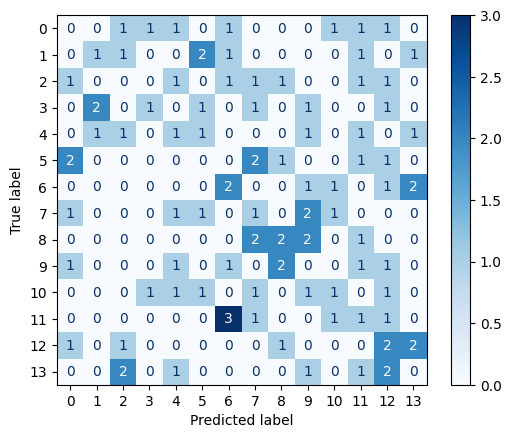

In [12]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.Input(shape= [128, 128, 3]),
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

#Compile the model using categorical cross-entropy as the loss function and accuracy as the evaluation metric
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=10,
    validation_data= val_ds,
    verbose = True
)

# Predict class probabilities
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = []
for _, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

# Compute extra metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

metrics = {
    'accuracy': accuracy_score(y_true, y_pred),
    'precision': precision_score(y_true, y_pred, average='weighted'),
    'recall': recall_score(y_true, y_pred, average='weighted'),
    'f1': f1_score(y_true, y_pred, average='weighted')
}

print(metrics)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')



In [18]:
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(128,128,3)),
        tf.keras.layers.RandomFlip(hp.Choice('flip', ['horizontal', 'vertical', 'horizontal_and_vertical'])),
        tf.keras.layers.RandomRotation(hp.Float('rotation', 0.0, 0.3, step=0.05)),
        tf.keras.layers.RandomZoom(hp.Float('zoom', 0.0, 0.3, step=0.05)),
        tf.keras.layers.RandomTranslation(height_factor=hp.Float('translation', 0.0, 0.3, step=0.05), width_factor=hp.Float('translation', 0.0, 0.3, step=0.05)),
        tf.keras.layers.RandomContrast(hp.Float('contrast', 0.0, 0.3, step=0.05)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(
            filters=hp.Int('filters_1', min_value=16, max_value=64, step=16),
            kernel_size=(3,3),
            activation='relu',
            padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
            kernel_size=(3,3),
            activation='relu',
            padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
            activation='relu'),
        tf.keras.layers.Dropout(rate=hp.Float('dropout', 0.0, 0.5, step=0.1)),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='flowers_aug'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_ds, validation_data=val_ds, epochs=20, callbacks=[stop_early])

best_hp = tuner.get_best_hyperparameters()[0]
print(f"Best learning rate: {best_hp.get('lr')}")
print(f"Best filters_1: {best_hp.get('filters_1')}")
print(f"Best dense_units: {best_hp.get('dense_units')}")
print(f"Best dense_units: {best_hp.get('dropout')}")
print(f"Best flip: {best_hp.get('flip')}")
print(f"Best zoom: {best_hp.get('zoom')}")
print(f"Best rotation: {best_hp.get('rotation')}")
print(f"Best translation: {best_hp.get('translation')}")
print(f"Best contrast: {best_hp.get('contrast')}")



Trial 26 Complete [00h 05m 36s]
val_accuracy: 0.6938775777816772

Best val_accuracy So Far: 0.7755101919174194
Total elapsed time: 01h 12m 38s
Best learning rate: 0.0012533452698519777
Best filters_1: 32
Best dense_units: 192
Best dense_units: 0.0
Best flip: horizontal
Best zoom: 0.0
Best rotation: 0.0
Best translation: 0.15000000000000002
Best contrast: 0.1


Part 5: Performance Evaluation And Analysis

1. Objective: Thoroughly evaluate the model’s performance.
2. Task:

Plot the training and validation accuracy and loss curves. Analyze these plots for signs of overfitting or underfitting.
Calculate other relevant metrics like precision, recall, F1-score, and confusion matrix. How does the model perform on each flower class? Are there any classes that are particularly difficult to classify?
Visualize the model’s predictions on a set of test images. Identify any misclassifications and try to understand why they occurred.

Epoch 1/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.2893 - loss: 2.4769 - val_accuracy: 0.5306 - val_loss: 1.4731
Epoch 2/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5033 - loss: 1.4089 - val_accuracy: 0.6224 - val_loss: 1.1381
Epoch 3/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.5733 - loss: 1.2171 - val_accuracy: 0.6837 - val_loss: 0.9390
Epoch 4/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6176 - loss: 1.1023 - val_accuracy: 0.7143 - val_loss: 0.9338
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.6509 - loss: 1.0191 - val_accuracy: 0.7245 - val_loss: 0.8093
Epoch 6/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6707 - loss: 0.9519 - val_accuracy: 0.7245 - val_loss: 0.7864
Epoch 7/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.6862 - loss: 0.9196 - val_accuracy: 0.7551 - val_loss: 0.7834
Epoch 8/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.7028 - loss: 0.8719 - 

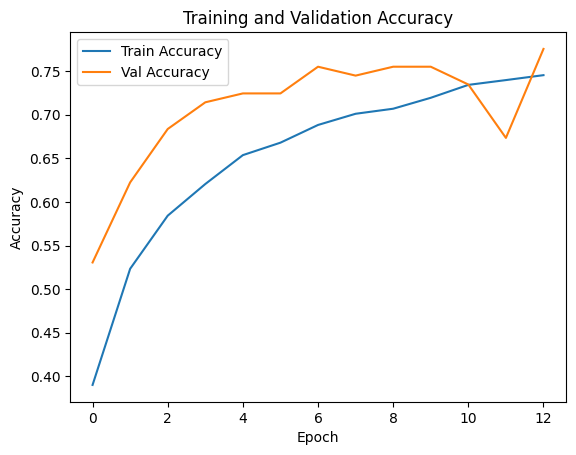

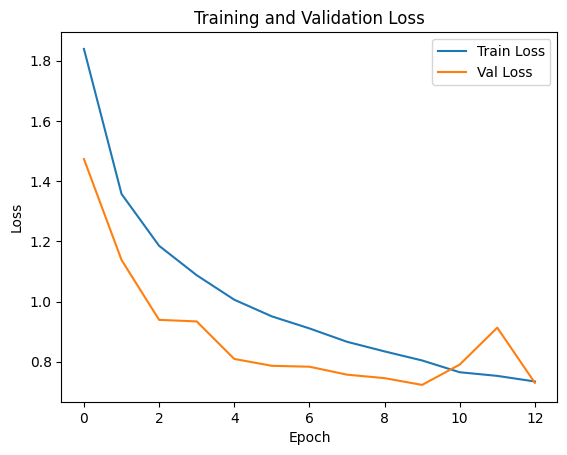

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
                  precision    recall  f1-score   support

         astilbe       0.00      0.00      0.00         7
      bellflower       0.00      0.00      0.00         7
black_eyed_susan       0.00      0.00      0.00         7
       calendula       0.17      0.14      0.15         7
california_poppy       0.00      0.00      0.00         7
       carnation       0.22      0.29      0.25         7
    common_daisy       0.00      0.00      0.00         7
       coreopsis       0.14      0.14      0.14         7
       dandelion       0.12      0.14      0.13         7
            iris       0.00      0.00      0.00         7
            rose       0.33      0.14      0.20         7
       sunflower       0.00      0.00      0.00         7
           tulip       0.00      0.00      0.00         7
      water_lily       0.00      0.00      0.00         7

        accuracy                           0.06        98
       macro avg       0.07     

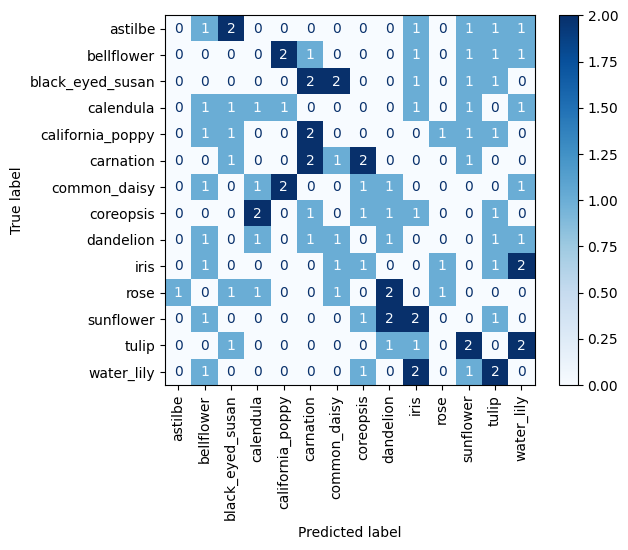

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


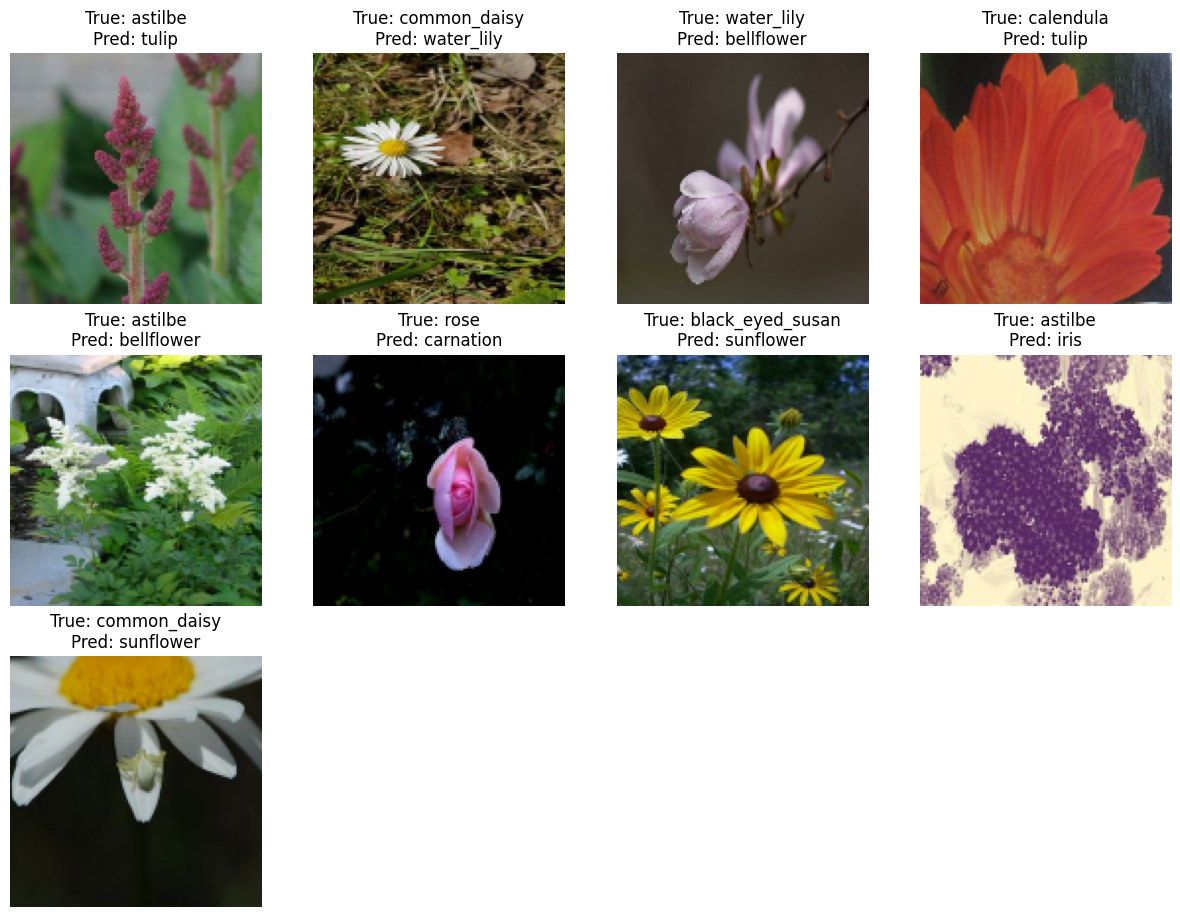

In [20]:
model = tf.keras.Sequential([
        tf.keras.Input(shape=(128,128,3)),
        tf.keras.layers.RandomFlip(best_hp.get('flip')),
        tf.keras.layers.RandomRotation(best_hp.get('rotation')),
        tf.keras.layers.RandomZoom(best_hp.get('zoom')),
        tf.keras.layers.RandomTranslation(height_factor=best_hp.get('translation'), width_factor=best_hp.get('translation')),
        tf.keras.layers.RandomContrast(best_hp.get('contrast')),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(
            filters=best_hp.get('filters_1'),
            kernel_size=(3,3),
            activation='relu',
            padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filters=best_hp.get('filters_2'),
            kernel_size=(3,3),
            activation='relu',
            padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=best_hp.get('dense_units'),
            activation='relu'),
        tf.keras.layers.Dropout(best_hp.get('dropout')),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=best_hp.get('lr')),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Watch validation loss
    patience=3,           # Stop after 3 epochs with no improvement
    restore_best_weights=True  # Optional: rollback to the best weights
)

history = model.fit(
    train_ds,
    epochs=30,            # Let it run for enough epochs to find the best spot
    validation_data=val_ds,
    callbacks=[stop_early],   # 👈 Add the callback here!
    verbose=True
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get predictions
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = []
for _, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

# Full report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

import matplotlib.pyplot as plt

# Take some val_ds images & labels
val_images = []
val_labels = []

for img_batch, label_batch in val_ds.take(1):  # one batch
    val_images = img_batch.numpy()
    val_labels = label_batch.numpy()

# Predict
pred_probs = model.predict(val_images)
pred_labels = np.argmax(pred_probs, axis=1)

# Show some misclassified
plt.figure(figsize=(15, 15))
wrong_idx = np.where(pred_labels != val_labels)[0]

for i, idx in enumerate(wrong_idx[:16]):
    plt.subplot(4, 4, i+1)
    plt.imshow(val_images[idx].astype("uint8"))
    plt.title(f'True: {class_names[val_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}')
    plt.axis('off')

plt.show()
